<a href="https://colab.research.google.com/github/Asura3301/makemore/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main reference paper - ["Kaiming init" paper | Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852)

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
words = open("/content/drive/MyDrive/Colab Notebooks/Projects/makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [20]:
len(words)

32033

In [21]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 # EOS/SOS
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [22]:
# build the dataset(train_test_split)
block_size = 3 # context length:how many characters we take to predict next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print("".join(itos[i] for i in context), "--->", itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%
Xval, Yval = build_dataset(words[n1:n2])    # 10%
Xte, Yte = build_dataset(words[n2:])        # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
# MLP
n_embd = 10       # the dimensionality of the character embedding vectors
n_hidden = 200    # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # std = gain / fan_mode**0.5 | we have tanh func -> gain = 5/3
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # num of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [71]:
# approximate expected loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

tensor(0.0163) tensor(0.9904)
tensor(0.0042) tensor(0.9765)


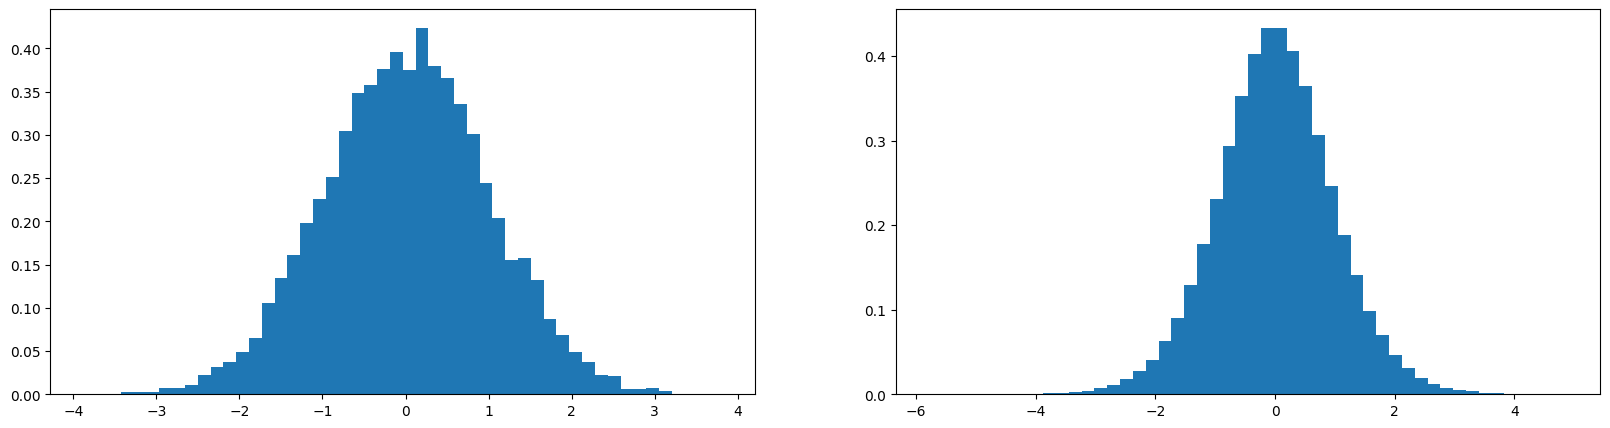

In [69]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [72]:
# optimization step
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embedding of X
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # logits(output layer of nn)
  loss = F.cross_entropy(logits, Yb) # loss function


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2956
  10000/ 200000: 2.3607
  20000/ 200000: 2.5141
  30000/ 200000: 2.2044
  40000/ 200000: 2.0599
  50000/ 200000: 1.8871
  60000/ 200000: 2.0569
  70000/ 200000: 2.3450
  80000/ 200000: 2.2624
  90000/ 200000: 1.9780
 100000/ 200000: 2.1673
 110000/ 200000: 2.0812
 120000/ 200000: 1.9038
 130000/ 200000: 2.1975
 140000/ 200000: 1.8419
 150000/ 200000: 2.1179
 160000/ 200000: 2.1798
 170000/ 200000: 1.7877
 180000/ 200000: 2.3487
 190000/ 200000: 1.9413


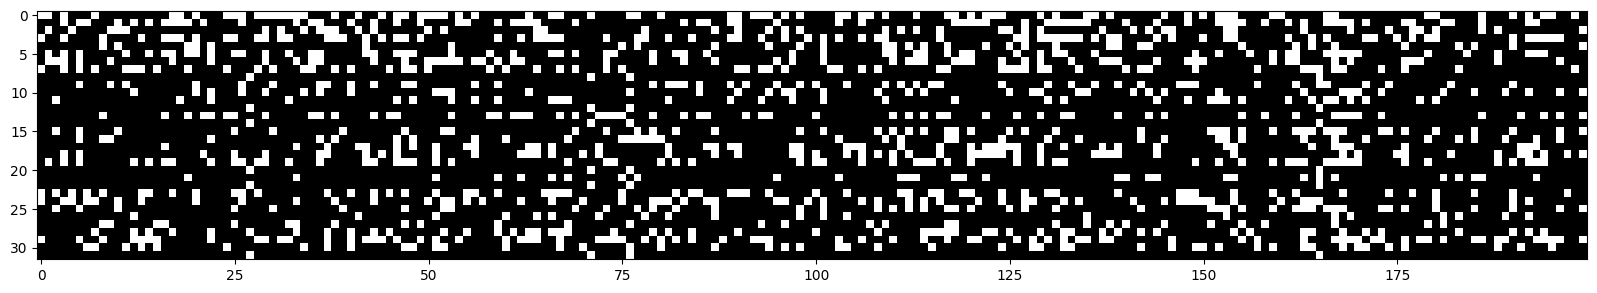

In [73]:
# fixing saturated neurons problem
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

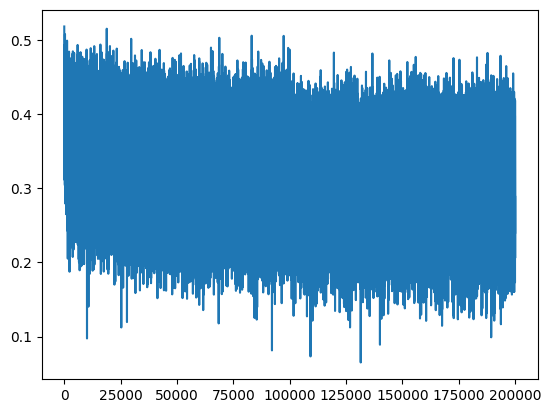

In [74]:
plt.plot(lossi)

In [75]:
# evaluation of optimization
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      "train": (Xtr, Ytr),
      "val": (Xval, Yval),
      "test": (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0387990474700928
val 2.1068685054779053


In [ ]:
# loss log

# original:
train = 2.13
val = 2.17

# fix softmax confidently wrong:
train = 2.07
val = 2.13

# fix tanh layer too saturated an initialization
train = 2.038249969482422
val = 2.1049816608428955

# fix init scale fo W1 to avoid changing of standard deviation, using kaiming_init
train = 2.0387990474700928
val = 2.1068685054779053

In [76]:
# sample the model
g = torch.Generator().manual_seed(42)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize
  while True:
    # forward pass of nn
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample special "." eos/sos token, break
    if ix == 0:
      break

  print("".join(itos[i] for i in out)) # decode and print the generated word

yeosyah.
malin.
dlee.
khalei.
jyantayvie.
chel.
emberlynn.
ize.
yukelea.
lou.
topheovani.
pepoltyn.
zakelsenalay.
whina.
luna.
adari.
zeriaqueen.
kersemale.
eiliony.
rany.
